# Adaptive distance

[ABC](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#approximate-bayesian-computation) provides means to sample an approximate posterior distribution over unknown parameters based on comparison between observed and simulated data. 
This comparison is often based on distance between features that summarise the data and are informative about the parameter values.

Here we assume that the summaries calculated based on observed and simulated data are compared based on weighted distance with weight $w_i=1/\sigma_i$ calculated based on their standard deviation $\sigma_i$.
This ensures that the selected summaries to have an equal contribution in the distance between observed and simulated data.

This notebook studies [adaptive distance](https://projecteuclid.org/euclid.ba/1460641065) [SMC-ABC](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#sequential-monte-carlo-abc) where $\sigma_i$ and $w_i$ are recalculated between SMC iterations as proposed in [[1](#Reference)]. 

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import elfi

## Example 1:

Assume we have an unknown parameter with prior distribution $\theta\sim U(0,50)$ and two simulator outputs $S_1\sim N(\theta, 1)$ and $S_2\sim N(\theta, 100)$ whose observed values are 20.

In [3]:
def simulator(mu, batch_size=1, random_state=None):
    
    batches_mu = np.asarray(mu).reshape((-1,1))
    
    obs_1 = ss.norm.rvs(loc=batches_mu, scale=1, random_state=random_state).reshape((-1,1))
    obs_2 = ss.norm.rvs(loc=batches_mu, scale=100, random_state=random_state).reshape((-1,1))
    
    return np.hstack((obs_1, obs_2))

In [4]:
observed_data = np.array([20,20])[None,:]

Here the simulator outputs are both informative about the unknown model parameter, but $S_2$ has more observation noise than $S_1$. We do not calculate separate summaries in this example, but compare observed and simulated data based on these two variables.

Euclidean distance between observed and simulated outputs or summaries can be used to find parameter values that could produce the observed data. Here we describe dependencies between the unknown parameter value and observed distances as an ELFI model `m` and sample the approximate posterior distribution with the [rejection sampler](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#inference-with-rejection-sampling).

In [5]:
m = elfi.new_model()
theta = elfi.Prior(ss.uniform, 0, 50, model=m)
sim = elfi.Simulator(simulator, theta, observed=observed_data)
d = elfi.Distance('euclidean', sim)

In [6]:
rej = elfi.Rejection(d, batch_size=10000, seed=123)

Let us sample 100 parameters with `quantile=0.01`. This means that we sample 10000 candidate parameters from the prior distribution and take the 100 parameters that produce simulated data closest to the observed data.

In [7]:
sample = rej.sample(100, quantile=0.01)

Progress [==================================================] 100.0% Complete


In [8]:
sample

Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 6.66
Sample means: theta: 19.6

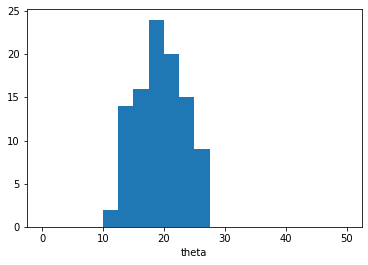

In [9]:
plt.hist(sample.samples_array,range=(0,50),bins=20)
plt.xlabel('theta');

The approximate posterior sample is concentrated around $\theta=20$ as expected in this example. However the sample distribution is much wider than we would observe in case the sample was selected based on $S_1$ alone.

Now let us test adaptive distance in the same example. 

First we switch the distance node `d` to an adaptive distance node and initialise adaptive distance SMC-ABC. Initialisation is identical to the rejection sampler, and here we use the same batch size and seed as earlier, so that the methods are presented with the exact same candidate parameters.

In [10]:
d.become(elfi.AdaptiveDistance(sim))

In [11]:
ada_smc = elfi.AdaptiveDistanceSMC(d, batch_size=10000, seed=123)

Since this is an iterative method, we must decide both sample size (`n_samples`) and how many populations are sampled (`rounds`). In addition we can decide the $\alpha$ quantile (`quantile`) used in estimation. 

Each population with `n_samples` parameter values is sampled as follows: 1. `n_samples/quantile` parameters are sampled from the current proposal distribution with acceptance threshold determined based on the previous population and 2. the distance measure is updated based on the observed sample and `n_samples` with the smallest distance are selected as the new population. The first population is sampled from the prior distribution and all samples are accepted in step 1.

Here we sample one population with `quantile=0.01`. This means that the total simulation count will be the same as with the rejection sampler, but now the distance function is updated based on the 10000 simulated observations, and the 100 parameters included in the posterior sample are selected based on the new distance measure.

In [12]:
sample_ada = ada_smc.sample(100, 1, quantile=0.01)

ABC-SMC Round 1 / 1
Progress [==================================================] 100.0% Complete


In [13]:
sample_ada

Method: AdaptiveDistanceSMC
Number of samples: 100
Number of simulations: 10000
Threshold: 0.462
Sample means: theta: 19.8

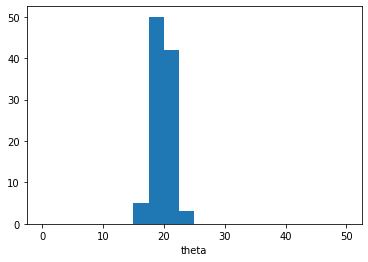

In [14]:
plt.hist(sample_ada.samples_array,range=(0,50),bins=20)
plt.xlabel('theta');

We see that the posterior distribution over unknown parameter values is narrower than in the previous example. This is because the simulator outputs are now normalised based on their estimated standard deviation. 

We can see $w_1$ and $w_2$:

In [15]:
sample_ada.adaptive_distance_w

[array([0.06940134, 0.0097677 ])]

## Example 2:

This is the normal distribution example presented in [[1](#Reference)]. 

Here we have an unknown parameter with prior distribution $\theta\sim N(0,100)$ and two simulator outputs $S_1\sim N(\theta, 0.1)$ and $S_2\sim N(1, 1)$ whose observed values are 0. 

In [16]:
def simulator(mu, batch_size=1, random_state=None):
    
    batches_mu = np.asarray(mu).reshape((-1,1))
    
    obs_1 = ss.norm.rvs(loc=batches_mu, scale=0.1, random_state=random_state).reshape((-1,1))
    obs_2 = ss.norm.rvs(loc=1, scale=1, size=batch_size, random_state=random_state).reshape((-1,1))
    
    return np.hstack((obs_1, obs_2))

In [17]:
observed_data = np.array([0,0])[None,:]

$S_1$ is now informative and $S_2$ uninformative about the unknown parameter value, and we note that between the two output variables, $S_1$ has larger variance under the prior predictive distribution. This means that normalisation estimated based on output data observed in the initial round or based on a separate sample would not work well in this example.

Let us define a new model and initialise adaptive distance SMC-ABC.

In [18]:
m = elfi.new_model()
theta = elfi.Prior(ss.norm, 0, 100, model=m)
sim = elfi.Simulator(simulator, theta, observed=observed_data)
d = elfi.AdaptiveDistance(sim)

In [19]:
ada_smc = elfi.AdaptiveDistanceSMC(d, batch_size=2000, seed=123)

Next we sample 1000 parameter values in 5 rounds with the default `quantile=0.5` which is recommended in sequential estimation [[1](#Reference)]:

In [20]:
sample_ada = ada_smc.sample(1000, 5)

ABC-SMC Round 1 / 5
Progress [==================================================] 100.0% Complete
ABC-SMC Round 2 / 5
Progress [==================================================] 100.0% Complete
ABC-SMC Round 3 / 5
Progress [==================================================] 100.0% Complete
ABC-SMC Round 4 / 5
Progress [==================================================] 100.0% Complete
ABC-SMC Round 5 / 5
Progress [==================================================] 100.0% Complete


In [21]:
sample_ada

Method: AdaptiveDistanceSMC
Number of samples: 1000
Number of simulations: 32000
Threshold: 0.925
Sample means: theta: -0.195

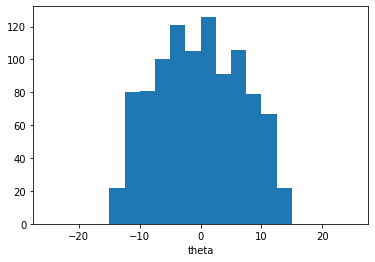

In [22]:
plt.hist(sample_ada.samples_array, range=(-25,25), bins=20)
plt.xlabel(theta);

The sample distribution is concentrated around $\theta=0$ but wider than could be expected. However we can continue the iterative estimation process. Here we sample two more populations:

In [23]:
sample_ada = ada_smc.sample(1000, 2)

ABC-SMC Round 6 / 7
Progress [==================================================] 100.0% Complete
ABC-SMC Round 7 / 7
Progress [==================================================] 100.0% Complete


In [24]:
sample_ada

Method: AdaptiveDistanceSMC
Number of samples: 1000
Number of simulations: 48000
Threshold: 0.868
Sample means: theta: 0.0183

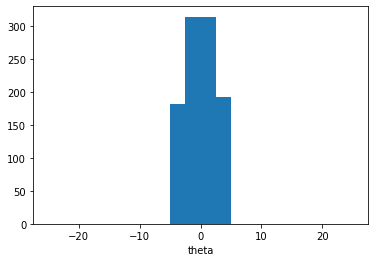

In [25]:
plt.hist(sample_ada.samples_array, range=(-25,25), bins=20)
plt.xlabel('theta');

We observe that the sample mean is now closer to zero and the sample distribution is narrower.

Let us examine $w_1$ and $w_2$:

In [26]:
sample_ada.adaptive_distance_w

[array([0.01023228, 1.00584519]),
 array([0.00921258, 0.99287166]),
 array([0.01201937, 0.99365522]),
 array([0.02217631, 0.98925365]),
 array([0.04355987, 1.00076738]),
 array([0.07863284, 0.9971017 ]),
 array([0.13892778, 1.00929049])]

We can see that $w_2$ (second column) is constant across iterations whereas $w_1$ increases as the method learns more about possible parameter values and the proposal distribution becomes more concentrated around $\theta=0$.

## Notes

The adaptive distance SMC-ABC method demonstrated in this notebook normalises simulator outputs or summaries calculated based on simulator output based on their estimated standard deviation under the proposal distribution in each iteration. This ensures that all outputs or summaries have an equal contribution to the distance between simulated and observed data in all iterations. 

It is important to note that the method does not evaluate whether outputs or summaries are needed or informative. In both examples studied in this notebook, results would improve if inference was carried out based on $S_1$ alone. Hence one should choose the summaries used in adaptive distance SMC-ABC with the usual care. ELFI tools that aid in the selection process are discussed in the diagnostics notebook available [here](https://github.com/elfi-dev/notebooks/tree/master).

## Reference

[1] Prangle D (2017). Adapting the ABC Distance Function. Bayesian Analysis 12(1): 289-309, 2017. https://projecteuclid.org/euclid.ba/1460641065